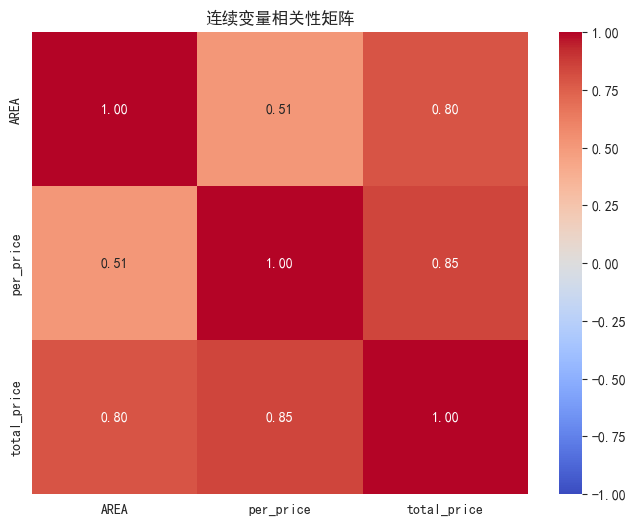

In [3]:
# =============================================================================
# （五）多变量关系分析
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab

# ===========================
# 0. 基础设置
# ===========================
pylab.rcParams['font.sans-serif'] = ['SimHei']
pylab.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_excel(r'E:\shenzhen_house_price_project\data\clean\清洗后数据.xlsx')


# =============================================================================
# 5.1 连续变量相关性矩阵（Correlation）
# =============================================================================

num_cols = ['AREA', 'per_price', 'total_price']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title("连续变量相关性矩阵")
plt.show()



AREA 与 total_price 的相关性为 0.80：
表明房屋面积越大，总价越高，具有强正相关关系。这是符合常识的，面积是决定总价的主要因素之一。

per_price 与 total_price 的相关性为 0.85：
单价与总价高度正相关，说明在大多数情况下，高价区域或优质房源同时具备高单价和高总价。

AREA 与 per_price 的相关性为 0.51：
存在中等程度正相关，表明面积较大的房子往往单价也较高，但并非绝对。这可能反映“大户型溢价”现象（如改善型住宅），但也存在反例（如大面积普通住宅单价较低）。

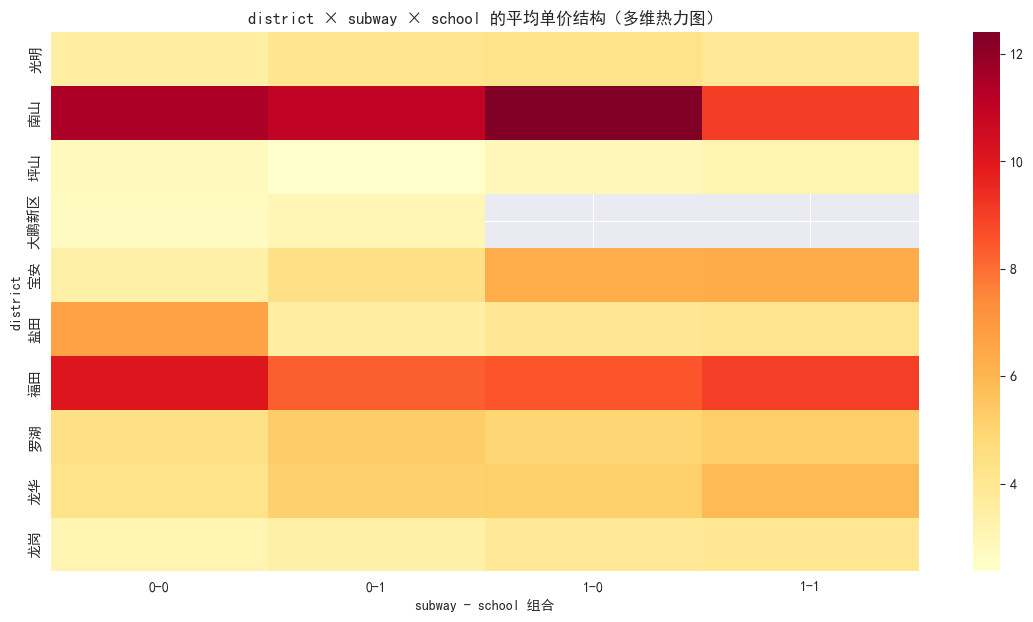

In [4]:
# =============================================================================
# 5.2 多维组合价格结构分析（district × subway × school）
# =============================================================================

# Step 1：计算 district × subway × school 的均价
group_multi = (
    df.groupby(['district', 'subway', 'school'])['per_price']
      .mean()
      .reset_index()
)

# Step 2：透视表
pivot_multi = group_multi.pivot_table(
    index='district',
    columns=['subway', 'school'],
    values='per_price'
)

plt.figure(figsize=(14, 7))
sns.heatmap(
    pivot_multi,
    cmap='YlOrRd',
    annot=False
)
plt.title("district × subway × school 的平均单价结构（多维热力图）")
plt.xlabel("subway - school 组合")
plt.ylabel("district")
plt.show()



南山、福田、罗湖整体均价最高，尤其在 1-1（地铁+学区）组合下达到峰值（接近12万元/㎡），显示这些核心城区拥有最强的资源集聚效应。

光明、坪山、大鹏新区无论何种组合，均价都偏低，说明这些区域尚未形成成熟的高端住宅市场。

在相同区域内部，1-1 组合普遍比其他组合高出明显，尤其是南山、福田，体现出“双优属性”带来的显著溢价。

盐田、龙岗部分区域在 1-1 下也有提升，但幅度较小，可能受限于供给结构或教育质量。

值得注意的是，宝安虽然在 1-1 下表现尚可，但在 0-0 下仍保持一定价位，说明其基础房价支撑较强。

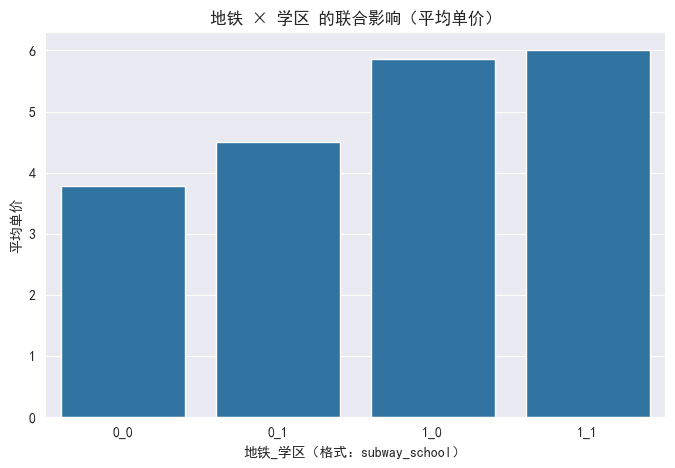

In [5]:
# =============================================================================
# 5.3 联合影响分析：地铁 × 学区 对房价的影响
# =============================================================================

df['subway_school'] = df['subway'].astype(str) + "_" + df['school'].astype(str)

interact_price = (
    df.groupby('subway_school')['per_price']
      .mean()
      .sort_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=interact_price.index,
    y=interact_price.values
)
plt.title("地铁 × 学区 的联合影响（平均单价）")
plt.xlabel("地铁_学区（格式：subway_school）")
plt.ylabel("平均单价")
plt.show()

平均单价从低到高依次为：

0_0：约3.8万元/㎡

0_1：约4.5万元/㎡

1_0：约5.9万元/㎡

1_1：约6.0万元/㎡

可见：

仅拥有学区（0_1）比无任何优势（0_0）提升约18%；

仅拥有地铁（1_0）提升更为显著，达55%；

同时具备两者（1_1）价格最高，略高于单地铁组，体现互补叠加效应。

In [6]:
# =============================================================================
# 5.4 高阶交互：地铁 × 学区 对“面积→单价”关系的影响（pandas版）
# =============================================================================

results = []

# 对每个组合（subway_school）计算：
# ① AREA-per_price 相关性
# ② 线性斜率 slope = cov(x,y) / var(x)
for combo, sub_df in df.groupby('subway_school'):

    if len(sub_df) < 5:  # 样本量太小跳过
        continue

    corr = sub_df['AREA'].corr(sub_df['per_price'])
    slope = np.cov(sub_df['AREA'], sub_df['per_price'])[0,1] / np.var(sub_df['AREA'])

    results.append([combo, corr, slope])

df_interaction = pd.DataFrame(
    results,
    columns=['group（subway_school）', '面积-单价相关系数', '面积影响斜率（slope）']
)

print("\n================ 多变量交互效应：AREA→per_price 在不同组合下的差异 ================\n")
print(df_interaction.sort_values('面积-单价相关系数', ascending=False))



================ 多变量交互效应：AREA→per_price 在不同组合下的差异 ================

  group（subway_school）  面积-单价相关系数  面积影响斜率（slope）
2                  1_0   0.569646       0.037428
1                  0_1   0.562552       0.028279
0                  0_0   0.484511       0.030568
3                  1_1   0.445797       0.031605


面积对单价的影响在“有地铁”条件下更强：

1_0 组的斜率为 0.037428，是所有组合中最高的，意味着在有地铁但无学区的情况下，面积每增加一单位，单价上涨幅度最大。

这可能是因为地铁沿线的房产更注重居住空间效率，大户型更具吸引力。

“双优”组合（1_1）反而弱化了面积的影响：

尽管单价高，但面积与单价的相关性最低（0.446），且斜率仅0.0316，说明在此类优质房产中，地段和配套已主导价格，面积不再是主要驱动力。

无地铁也无学区（0_0）：面积影响较弱，且相关性最低，说明这类房产价格更多取决于基础条件而非扩展性。